In [2]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (osxkeychain).
Your token has been saved to /Users/yusuke-fukasawa/.cache/huggingface/token
Login successful


In [3]:
from datasets import load_dataset

In [45]:
dataset = load_dataset("imagefolder", data_dir="../experimental/imgs/", split='train')

Resolving data files:   0%|          | 0/299 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /Users/yusuke-fukasawa/.cache/huggingface/datasets/imagefolder/default-fdc801262c3a6a44/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


In [46]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 299
})

In [47]:
split_dataset = dataset.train_test_split(test_size=0.1)

In [48]:
from transformers import SwinForImageClassification, SwinConfig, TrainingArguments, Trainer

In [49]:
from datasets import load_metric

metric = load_metric("accuracy")

In [50]:
example = split_dataset["train"][10]
example

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=105x100>,
 'label': 1}

In [51]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/swin-base-patch4-window7-224-in22k")
feature_extractor

/Users/yusuke-fukasawa/Library/Caches/pypoetry/virtualenvs/poke-battle-logger-xYV7PrtE-py3.10/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [52]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
train_transforms = Compose(
        [
            RandomResizedCrop((feature_extractor.size["width"], feature_extractor.size["height"])),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize((feature_extractor.size["width"], feature_extractor.size["height"])),
            CenterCrop((feature_extractor.size["width"], feature_extractor.size["height"])),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [53]:
labels = split_dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[2]

'アーマーガア'

In [54]:
train_ds = split_dataset['train']
val_ds = split_dataset['test']

train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

In [55]:
from transformers import AutoFeatureExtractor, AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained("microsoft/swin-base-patch4-window7-224-in22k",
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True)

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224-in22k and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([21841, 1024]) in the checkpoint and torch.Size([102, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([21841]) in the checkpoint and torch.Size([102]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [56]:
model_name = "pokemon_image_classifier"
batch_size = 16

args = TrainingArguments(
    model_name,
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=20,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

In [57]:
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [58]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [59]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [60]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/Users/yusuke-fukasawa/Library/Caches/pypoetry/virtualenvs/poke-battle-logger-xYV7PrtE-py3.10/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,No log,4.645837,0.000000
1,No log,4.442483,0.033333
2,4.588600,4.231812,0.166667
4,4.588600,3.768491,0.300000
4,3.725000,3.362775,0.300000
5,3.725000,2.939171,0.333333
6,3.725000,2.540879,0.500000
8,2.424700,2.037956,0.633333
8,2.424700,1.611412,0.700000
9,1.361900,1.248516,0.833333


***** train metrics *****
  epoch                    =       18.82
  total_flos               = 370077386GF
  train_loss               =      1.7824
  train_runtime            =  0:21:40.90
  train_samples_per_second =       4.136
  train_steps_per_second   =       0.061


In [61]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =      18.82
  eval_accuracy           =     0.9333
  eval_loss               =     0.7069
  eval_runtime            = 0:00:03.06
  eval_samples_per_second =      9.802
  eval_steps_per_second   =      0.653


In [22]:
# 推論テスト
import cv2
from PIL import Image
from transformers import pipeline

classifier_pipe = pipeline(task="image-classification", model=trainer.model, feature_extractor=feature_extractor)
pokemon_image = cv2.imread("../template_images/labeled_pokemon_templates/アラブルタケ_1920.png")
pokemon_image2 = cv2.cvtColor(pokemon_image, cv2.COLOR_BGR2RGB)
pokemon_image3 = Image.fromarray(pokemon_image2)
classifier_pipe(pokemon_image3)

[{'score': 0.9883771538734436, 'label': 'アラブルタケ'},
 {'score': 0.001104199094697833, 'label': 'ハリテヤマ'},
 {'score': 0.0007938448106870055, 'label': 'ヒートロトム'},
 {'score': 0.0006930785602889955, 'label': 'ハピナス'},
 {'score': 0.0003589704865589738, 'label': 'ドドゲザン'}]

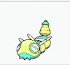

In [23]:
val_ds[0]['image']

In [24]:
classifier_pipe(val_ds[0]['image'])

[{'score': 0.6496335864067078, 'label': 'ノココッチ'},
 {'score': 0.025586964562535286, 'label': 'テツノカイナ'},
 {'score': 0.02314147725701332, 'label': 'モロバレル'},
 {'score': 0.014269602485001087, 'label': 'ウォッシュロトム'},
 {'score': 0.013751938939094543, 'label': 'ルチャブル'}]

In [62]:
for idx, _val in enumerate(val_ds):
    predict = classifier_pipe(_val['image'])
    _label = id2label[_val["label"]]
    print(idx, predict[0], _label)

0 {'score': 0.9861047863960266, 'label': 'キノガッサ'} キノガッサ
1 {'score': 0.9976893663406372, 'label': 'カイリュー'} カイリュー
2 {'score': 0.6496335864067078, 'label': 'ノココッチ'} ノココッチ
3 {'score': 0.9914306998252869, 'label': 'サーフゴー'} サーフゴー
4 {'score': 0.9912173748016357, 'label': 'サーフゴー'} サーフゴー
5 {'score': 0.9859327673912048, 'label': 'コノヨザル'} コノヨザル
6 {'score': 0.9791321754455566, 'label': 'トドロクツキ'} トドロクツキ
7 {'score': 0.9103250503540039, 'label': 'ドヒドイデ'} ドヒドイデ
8 {'score': 0.9924294352531433, 'label': 'ディンルー'} ディンルー
9 {'score': 0.964611291885376, 'label': 'ベトベトン'} ベトベトン
10 {'score': 0.9390482306480408, 'label': 'メタモン'} メタモン
11 {'score': 0.9389435648918152, 'label': 'マスカーニャ'} マスカーニャ
12 {'score': 0.9838091135025024, 'label': 'ウェーニバル'} ウェーニバル
13 {'score': 0.8798924684524536, 'label': 'ソウブレイズ'} ソウブレイズ
14 {'score': 0.992107093334198, 'label': 'サザンドラ'} サザンドラ
15 {'score': 0.9378718137741089, 'label': 'パルデアケンタロス水'} パルデアケンタロス水
16 {'score': 0.9927954077720642, 'label': 'ドドゲザン'} ドドゲザン
17 {'score': 0.974435687065

In [44]:
for idx, _train in enumerate(train_ds):
    predict = classifier_pipe(_train['image'])
    _label = id2label[_train["label"]]
    print(idx, predict[0], _label)

0 {'score': 0.9852884411811829, 'label': 'ラウドボーン'} ラウドボーン
1 {'score': 0.9815838932991028, 'label': 'ヌメルゴン'} ヌメルゴン
2 {'score': 0.79530268907547, 'label': 'ルチャブル'} ルチャブル
3 {'score': 0.9695276021957397, 'label': 'ライチュウ'} ライチュウ
4 {'score': 0.9555325508117676, 'label': 'イーユイ'} イーユイ
5 {'score': 0.9790841341018677, 'label': 'アラブルタケ'} アラブルタケ
6 {'score': 0.9848802089691162, 'label': 'パーモット'} パーモット
7 {'score': 0.9933816194534302, 'label': 'キラフロル'} キラフロル
8 {'score': 0.16889695823192596, 'label': 'ドヒドイデ'} ハルクジラ
9 {'score': 0.9695276021957397, 'label': 'ライチュウ'} ライチュウ
10 {'score': 0.9883771538734436, 'label': 'アラブルタケ'} アラブルタケ
11 {'score': 0.9927954077720642, 'label': 'ドドゲザン'} ドドゲザン
12 {'score': 0.9911308288574219, 'label': 'ディンルー'} ディンルー
13 {'score': 0.9241600036621094, 'label': 'カバルドン'} カバルドン
14 {'score': 0.9848802089691162, 'label': 'パーモット'} パーモット
15 {'score': 0.7392957210540771, 'label': 'チヲハウハネ'} チヲハウハネ
16 {'score': 0.9735182523727417, 'label': 'ガブリアス'} ガブリアス
17 {'score': 0.8926987648010254, 'la

144 {'score': 0.9789515137672424, 'label': 'タイカイデン'} タイカイデン
145 {'score': 0.964607298374176, 'label': 'テツノドクガ'} テツノドクガ
146 {'score': 0.36073070764541626, 'label': 'ルカリオ'} ルカリオ
147 {'score': 0.9501165747642517, 'label': 'パオジアン'} パオジアン
148 {'score': 0.7392957210540771, 'label': 'チヲハウハネ'} チヲハウハネ
149 {'score': 0.9935362935066223, 'label': 'ミミズズ'} ミミズズ
150 {'score': 0.47775065898895264, 'label': 'ブラッキー'} ブラッキー
151 {'score': 0.9881006479263306, 'label': 'サザンドラ'} サザンドラ
152 {'score': 0.964611291885376, 'label': 'ベトベトン'} ベトベトン
153 {'score': 0.9847123622894287, 'label': 'オーロンゲ'} オーロンゲ
154 {'score': 0.995428204536438, 'label': 'ハバタクカミ'} ハバタクカミ
155 {'score': 0.9891340136528015, 'label': 'ディンルー'} ディンルー
156 {'score': 0.9555325508117676, 'label': 'イーユイ'} イーユイ
157 {'score': 0.9913794994354248, 'label': 'ハバタクカミ'} ハバタクカミ
158 {'score': 0.9486728310585022, 'label': 'ハリテヤマ'} ハリテヤマ
159 {'score': 0.9369669556617737, 'label': 'アーマーガア'} アーマーガア
160 {'score': 0.7076679468154907, 'label': 'コータス'} コータス
161 {'score

In [63]:
from huggingface_hub import upload_file

upload_file(
    path_or_fileobj="pokemon_image_classifier/config.json",
    path_in_repo="config.json",
    repo_id="fufufukakaka/pokemon_image_classifier",
    create_pr=1
)

'https://huggingface.co/fufufukakaka/pokemon_image_classifier/blob/refs%2Fpr%2F10/config.json'

In [64]:
upload_file(
    path_or_fileobj="pokemon_image_classifier/pytorch_model.bin",
    path_in_repo="pytorch_model.bin",
    repo_id="fufufukakaka/pokemon_image_classifier",
    create_pr=1
)

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/348M [00:00<?, ?B/s]

'https://huggingface.co/fufufukakaka/pokemon_image_classifier/blob/refs%2Fpr%2F11/pytorch_model.bin'

In [65]:
upload_file(
    path_or_fileobj="pokemon_image_classifier/preprocessor_config.json",
    path_in_repo="preprocessor_config.json",
    repo_id="fufufukakaka/pokemon_image_classifier",
    create_pr=1
)

'https://huggingface.co/fufufukakaka/pokemon_image_classifier/blob/refs%2Fpr%2F12/preprocessor_config.json'